In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re
from ast import literal_eval
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException
import sklearn.metrics as metrics
from dmba import regressionSummary
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import Lasso
from sklearn import tree
import xgboost as xgb
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras import backend as K

C:\Users\vinay\miniforge3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# Importing Airbnb listing data
df_listing = pd.read_csv('listings.csv')

# Importing sentiment data we get from output of comments.ipynb file
df_reviews = pd.read_csv('reviews.csv')

# Feature Engineering and Data Cleaning

## Creating multiple features out of amenities column

In [3]:
# Find out all the unique amenities listed in amenities column
df_amenities = pd.DataFrame()
df_amenities['amenities'] = df_listing.amenities.apply(literal_eval)
amenities_list = []
for i in range(len(df_amenities)):
    amenities_list += df_amenities['amenities'][i]    
amenities_list = set(amenities_list)
amenities_list

{' Bath & Body Works shampoo',
 ' linens',
 ' toiletries',
 '21" HDTV with Roku, Chromecast',
 '24-hour fitness center',
 '32" HDTV',
 '32" HDTV with ',
 '32" HDTV with Amazon Prime Video, Chromecast, HBO Max, Netflix, Roku',
 '32" HDTV with Amazon Prime Video, HBO Max, Netflix, Roku, standard cable, Chromecast, premium cable',
 '32" HDTV with Amazon Prime Video, HBO Max, Netflix, premium cable, Roku, Chromecast, standard cable',
 '32" HDTV with Amazon Prime Video, HBO Max, Netflix, premium cable, Roku, standard cable, Chromecast',
 '32" HDTV with Amazon Prime Video, Netflix',
 '32" HDTV with Amazon Prime Video, Roku, Netflix',
 '32" HDTV with Netflix',
 '32" HDTV with Netflix, Amazon Prime Video',
 '32" HDTV with standard cable',
 '32" HDTV with standard cable, Amazon Prime Video, Chromecast, HBO Max, Netflix, premium cable, Roku',
 '32" HDTV with standard cable, premium cable',
 '36" HDTV with Apple TV',
 '37" HDTV with Amazon Prime Video, Apple TV, Netflix',
 '40" HDTV with Amazon P

In [4]:
# Cleaning the amenities text
lemmatizer = WordNetLemmatizer()
corpus = []
for i in range(len(df_listing)):
    amenity = re.sub('[^a-zA-Z]', ' ', df_listing.amenities[i]).lower().split()
    amenity = [lemmatizer.lemmatize(word) for word in amenity]
    amenity = ' '.join(amenity)
    corpus.append(amenity)
    
# Passing select list of amenities from amenities_list
count_vect = CountVectorizer(analyzer='word', ngram_range=(1, 4), binary = True, lowercase=False, 
                             vocabulary = ['speaker', 'sound system', 'oven', 'grill', 'backyard', 'garden', 'beachfront', 
                                           'bidet', 'bike', 'breakfast', 'concierge', 'shampoo', 'linen', 'hdtv', 'tv', 'stove',
                                           'air conditioning', 'ac', 'refrigerator', 'sauna', 'game console', 'heating',
                                           'housekeeping', 'pool', 'lake access', 'microwave', 'pet allowed', 'ev charger',
                                           'long term stay allowed', 'cleaning before checkout', 'dedicated workspace', 'dryer', 
                                           'wifi', 'gym', 'free parking', 'paid parking', 'free washer', 'paid washer'])
count_matrix = count_vect.fit_transform(corpus)
count_array = count_matrix.toarray()
df_amenities = pd.DataFrame(data=count_array,columns = count_vect.get_feature_names_out())
df_amenities.columns = df_amenities.columns.str.replace(' ','_')
df_amenities

,speaker,sound_system,oven,grill,backyard,garden,beachfront,bidet,bike,breakfast,...,long_term_stay_allowed,cleaning_before_checkout,dedicated_workspace,dryer,wifi,gym,free_parking,paid_parking,free_washer,paid_washer
0,0,0,1,0,0,0,0,0,0,0,...,1,0,1,1,1,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,1,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,1,0,1,1,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,1,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3344,0,0,1,1,1,0,0,0,0,0,...,1,0,1,1,1,0,0,0,0,0
3345,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,1,1,0,0,0,0
3346,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,1,1,0,0,0,0
3347,0,0,1,1,0,0,0,0,0,0,...,1,0,0,1,1,1,0,0,0,0


In [5]:
# Merging similar amenities into one new column
df_amenities['sound_system_or_speaker'] = np.logical_or(df_amenities['speaker'], df_amenities['sound_system']).astype(int)
df_amenities['backyard_or_garden'] = np.logical_or(df_amenities['backyard'], df_amenities['garden']).astype(int)
df_amenities['tv_or_hdtv'] = np.logical_or(df_amenities['tv'], df_amenities['hdtv']).astype(int)

# Remove the similar amenities columns
df_amenities.drop(['speaker', 'sound_system', 'backyard', 'garden', 'tv', 'hdtv'], axis = 1, inplace = True)
df_amenities

,oven,grill,beachfront,bidet,bike,breakfast,concierge,shampoo,linen,stove,...,dryer,wifi,gym,free_parking,paid_parking,free_washer,paid_washer,sound_system_or_speaker,backyard_or_garden,tv_or_hdtv
0,1,0,0,0,0,0,0,1,1,1,...,1,1,0,1,0,0,0,0,0,1
1,0,0,0,0,0,0,0,1,1,0,...,1,1,0,0,0,0,0,0,0,1
2,1,0,0,0,0,0,0,1,0,1,...,1,1,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,1,...,1,1,0,0,1,0,0,0,0,1
4,0,0,0,0,0,0,0,0,1,1,...,1,1,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3344,1,1,0,0,0,0,0,1,1,1,...,1,1,0,0,0,0,0,0,1,1
3345,0,0,0,0,0,0,0,1,0,0,...,1,1,1,0,0,0,0,0,0,1
3346,0,0,0,0,0,0,0,1,0,0,...,1,1,1,0,0,0,0,0,0,1
3347,1,1,0,0,0,0,0,1,1,1,...,1,1,1,0,0,0,0,0,0,1


In [6]:
# Merging the amenities data frame with listing data frame
df_combined = pd.concat([df_listing, df_amenities], axis=1)
df_combined

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,dryer,wifi,gym,free_parking,paid_parking,free_washer,paid_washer,sound_system_or_speaker,backyard_or_garden,tv_or_hdtv
0,3781,https://www.airbnb.com/rooms/3781,20211217003539,2021-12-17,HARBORSIDE-Walk to subway,Fully separate apartment in a two apartment bu...,"Mostly quiet ( no loud music, no crowed sidewa...",https://a0.muscache.com/pictures/24670/b2de044...,4804,https://www.airbnb.com/users/show/4804,...,1,1,0,1,0,0,0,0,0,1
1,5506,https://www.airbnb.com/rooms/5506,20211217003539,2021-12-17,** Private! Minutes to center!**,"Private guest room with private bath, You do n...","Peaceful, Architecturally interesting, histori...",https://a0.muscache.com/pictures/miso/Hosting-...,8229,https://www.airbnb.com/users/show/8229,...,1,1,0,0,0,0,0,0,0,1
2,6695,https://www.airbnb.com/rooms/6695,20211217003539,2021-12-17,Home Away from Home! Condo,"Comfortable, Fully Equipped private apartment...","Peaceful, Architecturally interesting, histori...",https://a0.muscache.com/pictures/38ac4797-e7a4...,8229,https://www.airbnb.com/users/show/8229,...,1,1,0,0,0,0,0,0,0,1
3,8789,https://www.airbnb.com/rooms/8789,20211217003539,2021-12-17,Curved Glass Studio/1bd facing Park,This unit is for sale. There will need to be o...,Beacon Hill is a historic neighborhood filled ...,https://a0.muscache.com/pictures/32210/7fdd2fd...,26988,https://www.airbnb.com/users/show/26988,...,1,1,0,0,1,0,0,0,0,1
4,10730,https://www.airbnb.com/rooms/10730,20211217003539,2021-12-17,Bright 1bed facing Golden Dome,"Bright, spacious unit, new galley kitchen, new...",Beacon Hill is located downtown and is conveni...,https://a0.muscache.com/pictures/miso/Hosting-...,26988,https://www.airbnb.com/users/show/26988,...,1,1,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3344,53827417,https://www.airbnb.com/rooms/53827417,20211217003539,2021-12-17,"Modern & Large Single Family, Come Enjoy Boston!",Perfect attached single family rental just out...,NaN,https://a0.muscache.com/pictures/prohost-api/H...,135841577,https://www.airbnb.com/users/show/135841577,...,1,1,0,0,0,0,0,0,1,1
3345,53827528,https://www.airbnb.com/rooms/53827528,20211217003539,2021-12-17,Perfect Location! Great Amenities Included!,"A beautiful, upscale apartment awaits you. Loc...",One of the most iconic neighborhoods located a...,https://a0.muscache.com/pictures/prohost-api/H...,423270067,https://www.airbnb.com/users/show/423270067,...,1,1,1,0,0,0,0,0,0,1
3346,53827594,https://www.airbnb.com/rooms/53827594,20211217003539,2021-12-17,Outstanding Upgraded Luxury Apt!,"A beautiful, upscale apartment awaits you. Loc...",One of the most iconic neighborhoods located a...,https://a0.muscache.com/pictures/prohost-api/H...,423270067,https://www.airbnb.com/users/show/423270067,...,1,1,1,0,0,0,0,0,0,1
3347,53839627,https://www.airbnb.com/rooms/53839627,20211217003539,2021-12-17,A home you will love | 1 BR in Boston,Stay for 91+ nights (minimum nights and rates ...,Pheasant Ridge community is perfectly situated...,https://a0.muscache.com/pictures/a4re/floorpla...,368944610,https://www.airbnb.com/users/show/368944610,...,1,1,1,0,0,0,0,0,0,1


## Creating sentiment feature from review comments

In [7]:
# Using vader sentiment analyzer on review comments to get sentiment
base_dict = dict(tuple(df_reviews.groupby('listing_id')))
sentiment = {}
no_en_comments = {}
sid = SentimentIntensityAnalyzer()
for listing_id in base_dict:
    if listing_id not in sentiment.keys():
        sentiment[listing_id] = 0
        no_en_comments[listing_id] = 0
    for comment in base_dict[listing_id]['comments']:
        comment_str = str(comment)
        if comment_str and comment_str.strip():
            try:
                if detect(comment_str) == 'en':
                    ss = sid.polarity_scores(comment_str)
                    sentiment[listing_id] += ss['compound']
                    no_en_comments[listing_id] += 1
            except LangDetectException:
                pass
    if no_en_comments[listing_id] != 0:
        sentiment[listing_id] /= no_en_comments[listing_id]

# Finding average sentiment value for each listing
df_sentiment = pd.DataFrame.from_dict(sentiment, orient = 'index', columns = ['sentiment'])
df_no_en_comments = pd.DataFrame.from_dict(no_en_comments, orient = 'index', columns = ['no_en_comments'])
df_comments = pd.concat([df_sentiment, df_no_en_comments], axis = 1, join = 'inner')
df_comments.reset_index(inplace = True)
df_comments = df_comments.rename(columns = {'index':'id'})
df_comments

,id,sentiment,no_en_comments
0,3781,0.880005,21
1,5506,0.847874,108
2,6695,0.878070,108
3,8789,0.883970,23
4,10730,0.909710,29
...,...,...,...
2345,53605000,0.893100,1
2346,53631121,0.944950,2
2347,53631585,0.359500,1
2348,53704154,0.796000,1


<AxesSubplot:xlabel='sentiment', ylabel='Count'>

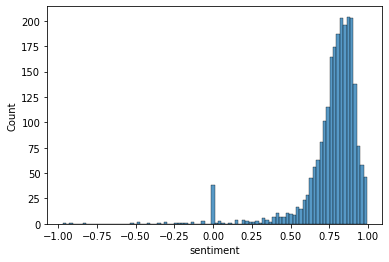

In [9]:
# Plotting histogram of average sentiment values
sns.histplot(df_comments.sentiment)

In [10]:
# Merging sentiment data with listing data
df_combined = df_combined.merge(df_comments, on = 'id', how = 'left')
df_combined

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,gym,free_parking,paid_parking,free_washer,paid_washer,sound_system_or_speaker,backyard_or_garden,tv_or_hdtv,sentiment,no_en_comments
0,3781,https://www.airbnb.com/rooms/3781,20211217003539,2021-12-17,HARBORSIDE-Walk to subway,Fully separate apartment in a two apartment bu...,"Mostly quiet ( no loud music, no crowed sidewa...",https://a0.muscache.com/pictures/24670/b2de044...,4804,https://www.airbnb.com/users/show/4804,...,0,1,0,0,0,0,0,1,0.880005,21.0
1,5506,https://www.airbnb.com/rooms/5506,20211217003539,2021-12-17,** Private! Minutes to center!**,"Private guest room with private bath, You do n...","Peaceful, Architecturally interesting, histori...",https://a0.muscache.com/pictures/miso/Hosting-...,8229,https://www.airbnb.com/users/show/8229,...,0,0,0,0,0,0,0,1,0.847874,108.0
2,6695,https://www.airbnb.com/rooms/6695,20211217003539,2021-12-17,Home Away from Home! Condo,"Comfortable, Fully Equipped private apartment...","Peaceful, Architecturally interesting, histori...",https://a0.muscache.com/pictures/38ac4797-e7a4...,8229,https://www.airbnb.com/users/show/8229,...,0,0,0,0,0,0,0,1,0.878070,108.0
3,8789,https://www.airbnb.com/rooms/8789,20211217003539,2021-12-17,Curved Glass Studio/1bd facing Park,This unit is for sale. There will need to be o...,Beacon Hill is a historic neighborhood filled ...,https://a0.muscache.com/pictures/32210/7fdd2fd...,26988,https://www.airbnb.com/users/show/26988,...,0,0,1,0,0,0,0,1,0.883970,23.0
4,10730,https://www.airbnb.com/rooms/10730,20211217003539,2021-12-17,Bright 1bed facing Golden Dome,"Bright, spacious unit, new galley kitchen, new...",Beacon Hill is located downtown and is conveni...,https://a0.muscache.com/pictures/miso/Hosting-...,26988,https://www.airbnb.com/users/show/26988,...,0,0,1,0,0,0,0,1,0.909710,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3344,53827417,https://www.airbnb.com/rooms/53827417,20211217003539,2021-12-17,"Modern & Large Single Family, Come Enjoy Boston!",Perfect attached single family rental just out...,NaN,https://a0.muscache.com/pictures/prohost-api/H...,135841577,https://www.airbnb.com/users/show/135841577,...,0,0,0,0,0,0,1,1,NaN,NaN
3345,53827528,https://www.airbnb.com/rooms/53827528,20211217003539,2021-12-17,Perfect Location! Great Amenities Included!,"A beautiful, upscale apartment awaits you. Loc...",One of the most iconic neighborhoods located a...,https://a0.muscache.com/pictures/prohost-api/H...,423270067,https://www.airbnb.com/users/show/423270067,...,1,0,0,0,0,0,0,1,NaN,NaN
3346,53827594,https://www.airbnb.com/rooms/53827594,20211217003539,2021-12-17,Outstanding Upgraded Luxury Apt!,"A beautiful, upscale apartment awaits you. Loc...",One of the most iconic neighborhoods located a...,https://a0.muscache.com/pictures/prohost-api/H...,423270067,https://www.airbnb.com/users/show/423270067,...,1,0,0,0,0,0,0,1,NaN,NaN
3347,53839627,https://www.airbnb.com/rooms/53839627,20211217003539,2021-12-17,A home you will love | 1 BR in Boston,Stay for 91+ nights (minimum nights and rates ...,Pheasant Ridge community is perfectly situated...,https://a0.muscache.com/pictures/a4re/floorpla...,368944610,https://www.airbnb.com/users/show/368944610,...,1,0,0,0,0,0,0,1,NaN,NaN


## Dimension reduction utilizing domain knowledge

In [12]:
# percentage of values that are missing
total_null = df_combined.isna().sum().sort_values(ascending=False)
percentage_null = (total_null / df_combined.shape[0]) * 100
tabel_null = pd.concat([total_null, percentage_null], axis=1, keys=['Total Null values', 'Percentage of Null values'])
print(tabel_null.head(60))
print(tabel_null.tail(60))

                              Total Null values  Percentage of Null values
neighbourhood_group_cleansed               3349                 100.000000
calendar_updated                           3349                 100.000000
bathrooms                                  3349                 100.000000
license                                    1500                  44.789489
host_about                                 1284                  38.339803
neighbourhood                              1192                  35.592714
neighborhood_overview                      1192                  35.592714
review_scores_checkin                      1012                  30.217976
review_scores_location                     1012                  30.217976
review_scores_value                        1012                  30.217976
review_scores_accuracy                     1011                  30.188116
review_scores_cleanliness                  1010                  30.158256
review_scores_communicati

>Listing url, scrape id, last_scraped are features which will not affect the price prediction so dropping them.

>Description contains information which is similar to information present in ammenities coulmn in an organized manner so dropping it.

>Neighbourhood information is available in form of latitude and longitude which can be used in more effective manner than neighborhood_overview.

>Project doesn't do image analysis so dropping clomns containing image urls like picture url, host_thumbnail_url, host_picture_url.

>Columns containing host information which which do not impact price prediction like host_id, host_url, host_name, host_since, host_location, host_about, host_verifications, host_is_superhost,host_neighbourhood, host_listings_count, host_total_listings_count, host_location, host_has_profile_pic.

>Dropping colums having lots of blank values like neighbourhood_group_cleansed, calendar_updated, bathrooms, license, neighbourhood.

>Removing columns with redunandant information like  minimum_minimum_nights, aximum_minimum_nights, minimum_maximum_nights, maximum_maximum_nights, minimum_nights_avg_ntm, maximum_nights_avg_ntm, review_scores_accuracy, review_scores_cleanliness, review_scores_communication, review_scores_checkin, review_scores_location.

>Removing columns least relevant to price prediction like  calendar_last_scraped, calculated_host_listings_count, calculated_host_listings_count_entire_homes, calculated_host_listings_count_private_rooms, calculated_host_listings_count_shared_rooms, name.

>Removing column amenities, which we have used to create multiple new features.

>Removing property_type as room_type provides similar information

In [13]:
# Removing above mentioned columns
drop_cols = ['listing_url','scrape_id','last_scraped','description','neighborhood_overview','picture_url','host_id',
             'host_url','host_name','host_since','host_location','host_about','host_is_superhost', 'host_verifications', 
             'host_thumbnail_url', 'host_picture_url','host_neighbourhood','host_listings_count','host_total_listings_count',
             'host_has_profile_pic', 'host_verifications', 'neighbourhood_group_cleansed','calendar_last_scraped',
             'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'property_type', 'amenities', 
             'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms','neighbourhood',
             'neighbourhood_group_cleansed', 'calendar_updated', 'license', 'minimum_minimum_nights','maximum_minimum_nights',
             'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm','maximum_nights_avg_ntm','bathrooms', 
             'first_review','last_review', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_communication',
             'review_scores_checkin', 'review_scores_location', 'name', 'has_availability']
df_combined = df_combined.drop(drop_cols, axis=1)

In [14]:
df_combined.columns

Index(['id', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_identity_verified',
       'neighbourhood_cleansed', 'latitude', 'longitude', 'room_type',
       'accommodates', 'bathrooms_text', 'bedrooms', 'beds', 'price',
       'minimum_nights', 'maximum_nights', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'review_scores_rating', 'review_scores_value', 'instant_bookable',
       'reviews_per_month', 'oven', 'grill', 'beachfront', 'bidet', 'bike',
       'breakfast', 'concierge', 'shampoo', 'linen', 'stove',
       'air_conditioning', 'ac', 'refrigerator', 'sauna', 'game_console',
       'heating', 'housekeeping', 'pool', 'lake_access', 'microwave',
       'pet_allowed', 'ev_charger', 'long_term_stay_allowed',
       'cleaning_before_checkout', 'dedicated_workspace', 'dryer', 'wifi',
       'gym', 'free_parking', 'paid_parking', 

In [15]:
df_combined

,id,host_response_time,host_response_rate,host_acceptance_rate,host_identity_verified,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,...,gym,free_parking,paid_parking,free_washer,paid_washer,sound_system_or_speaker,backyard_or_garden,tv_or_hdtv,sentiment,no_en_comments
0,3781,within a day,100%,44%,f,East Boston,42.364130,-71.029910,Entire home/apt,2,...,0,1,0,0,0,0,0,1,0.880005,21.0
1,5506,within an hour,100%,97%,t,Roxbury,42.328440,-71.095810,Entire home/apt,2,...,0,0,0,0,0,0,0,1,0.847874,108.0
2,6695,within an hour,100%,97%,t,Roxbury,42.328020,-71.093870,Entire home/apt,4,...,0,0,0,0,0,0,0,1,0.878070,108.0
3,8789,within a few hours,100%,60%,t,Beacon Hill,42.358670,-71.063070,Entire home/apt,2,...,0,0,1,0,0,0,0,1,0.883970,23.0
4,10730,within a few hours,100%,60%,t,Downtown,42.359060,-71.062710,Entire home/apt,2,...,0,0,1,0,0,0,0,1,0.909710,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3344,53827417,within an hour,97%,81%,t,Dorchester,42.291220,-71.049233,Entire home/apt,15,...,0,0,0,0,0,0,1,1,NaN,NaN
3345,53827528,within an hour,100%,100%,t,Back Bay,42.345112,-71.081662,Entire home/apt,8,...,1,0,0,0,0,0,0,1,NaN,NaN
3346,53827594,within an hour,100%,100%,t,Back Bay,42.343415,-71.081942,Entire home/apt,4,...,1,0,0,0,0,0,0,1,NaN,NaN
3347,53839627,NaN,NaN,NaN,NaN,South End,42.344434,-71.064646,Entire home/apt,3,...,1,0,0,0,0,0,0,1,NaN,NaN


## Converting all data to numerical values

In [16]:
# Remove % from host_response_rate and host_acceptance_rate
df_combined['host_response_rate'] = df_combined['host_response_rate'].str.strip('%')
df_combined['host_acceptance_rate'] = df_combined['host_acceptance_rate'].str.strip('%')

# Remove $ and , from price
df_combined['price'] = df_combined['price'].str.strip('$').str.replace(',','')

In [17]:
# Ordinal encoder function
def ordinal_encoder(df, feature, feature_rank):
    ordinal_dict = {}
    for i, value in enumerate(feature_rank):
        ordinal_dict[value] = i+1
    df[feature] = df[feature].map(lambda x : ordinal_dict[x], na_action = 'ignore')
    return df

In [18]:
# Find out all the unique values listed in host_response_time column
print(set(df_combined.host_response_time))

# Ordinal encoding of host_response_time
ordinal_encoder(df_combined, 'host_response_time', ['a few days or more', 'within a day', 'within a few hours', 'within an hour'])

# Find out all the unique values listed in room_type
print(set(df_combined.room_type))

# Ordinal encoding of host_response_time
ordinal_encoder(df_combined, 'room_type', ['Shared room', 'Hotel room', 'Private room', 'Entire home/apt'])

# Find out all the unique values listed in host_identity_verified
print(set(df_combined.host_identity_verified))

# Replacing t and f with 1 and 0
df_combined['host_identity_verified'] = df_combined['host_identity_verified'].map({'t': 1, 'f' : 0}, na_action = 'ignore')

# Find out all the unique values listed in instant_bookable
print(set(df_combined.instant_bookable))

# Replacing t and f with 1 and 0
df_combined['instant_bookable'] = df_combined['instant_bookable'].map({'t': 1, 'f' : 0}, na_action = 'ignore')

df_combined

{nan, 'within a day', 'within a few hours', 'within an hour', 'a few days or more'}
{'Shared room', 'Hotel room', 'Private room', 'Entire home/apt'}
{nan, 'f', 't'}
{'f', 't'}


,id,host_response_time,host_response_rate,host_acceptance_rate,host_identity_verified,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,...,gym,free_parking,paid_parking,free_washer,paid_washer,sound_system_or_speaker,backyard_or_garden,tv_or_hdtv,sentiment,no_en_comments
0,3781,2.0,100,44,0.0,East Boston,42.364130,-71.029910,4,2,...,0,1,0,0,0,0,0,1,0.880005,21.0
1,5506,4.0,100,97,1.0,Roxbury,42.328440,-71.095810,4,2,...,0,0,0,0,0,0,0,1,0.847874,108.0
2,6695,4.0,100,97,1.0,Roxbury,42.328020,-71.093870,4,4,...,0,0,0,0,0,0,0,1,0.878070,108.0
3,8789,3.0,100,60,1.0,Beacon Hill,42.358670,-71.063070,4,2,...,0,0,1,0,0,0,0,1,0.883970,23.0
4,10730,3.0,100,60,1.0,Downtown,42.359060,-71.062710,4,2,...,0,0,1,0,0,0,0,1,0.909710,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3344,53827417,4.0,97,81,1.0,Dorchester,42.291220,-71.049233,4,15,...,0,0,0,0,0,0,1,1,NaN,NaN
3345,53827528,4.0,100,100,1.0,Back Bay,42.345112,-71.081662,4,8,...,1,0,0,0,0,0,0,1,NaN,NaN
3346,53827594,4.0,100,100,1.0,Back Bay,42.343415,-71.081942,4,4,...,1,0,0,0,0,0,0,1,NaN,NaN
3347,53839627,NaN,NaN,NaN,NaN,South End,42.344434,-71.064646,4,3,...,1,0,0,0,0,0,0,1,NaN,NaN


In [19]:
# Find out all the unique values listed in neighbourhood_cleansed
print(set(df_combined.neighbourhood_cleansed))

# One hot encoding of neighbourhood_cleansed
transform = make_column_transformer((OneHotEncoder(drop = 'first'), ['neighbourhood_cleansed']), remainder='passthrough', 
                                    verbose_feature_names_out = False)
transformed = transform.fit_transform(df_combined)
df_combined = pd.DataFrame(transformed, columns=transform.get_feature_names_out())
df_combined.columns = df_combined.columns.str.replace(' ','_').str.lower()
df_combined

{'Jamaica Plain', 'South Boston Waterfront', 'South End', 'North End', 'Roxbury', 'West Roxbury', 'West End', 'Brighton', 'Dorchester', 'Beacon Hill', 'East Boston', 'South Boston', 'Bay Village', 'Allston', 'Fenway', 'Charlestown', 'Mission Hill', 'Downtown', 'Back Bay', 'Hyde Park', 'Roslindale', 'Chinatown', 'Longwood Medical Area', 'Mattapan', 'Leather District'}


,neighbourhood_cleansed_back_bay,neighbourhood_cleansed_bay_village,neighbourhood_cleansed_beacon_hill,neighbourhood_cleansed_brighton,neighbourhood_cleansed_charlestown,neighbourhood_cleansed_chinatown,neighbourhood_cleansed_dorchester,neighbourhood_cleansed_downtown,neighbourhood_cleansed_east_boston,neighbourhood_cleansed_fenway,...,gym,free_parking,paid_parking,free_washer,paid_washer,sound_system_or_speaker,backyard_or_garden,tv_or_hdtv,sentiment,no_en_comments
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,1,0,0,0,0,0,1,0.880005,21.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0.847874,108.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0.87807,108.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,1,0.88397,23.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,1,0,0,0,0,1,0.90971,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3344,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,1,NaN,NaN
3345,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,1,NaN,NaN
3346,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,1,NaN,NaN
3347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,1,NaN,NaN


In [20]:
# Find out all the unique values listed in bathrooms_text
print(set(df_combined.bathrooms_text))

# Ordinal encoding of bathrooms_text
dict_bath = {'0 baths':0, '0 shared baths':0, 'Shared half-bath':0.25, 'Half-bath':0.5, 'Private half-bath':0.5, 
             '1 shared bath':0.5, '1.5 shared baths':0.75, '1 bath':1, '1 private bath':1, '2 shared baths':1, 
             '2.5 shared baths':1.25, '1.5 baths':1.5, '3 shared baths':1.5, '3.5 shared baths':1.75, '2 baths':2, 
             '4 shared baths':2, '2.5 baths':2.5, '5 shared baths':2.5, '3 baths':3, '6 shared baths':3, '3.5 baths':3.5, 
             '4 baths':4, '4.5 baths':4.5, '5 baths':5, '6 baths':6}
df_combined['bathrooms_text'] = df_combined['bathrooms_text'].map(dict_bath, na_action = 'ignore')
df_combined['bathrooms_text']

{nan, '3.5 baths', '4 baths', '6 baths', '1 bath', '4.5 baths', '1 private bath', '3.5 shared baths', 'Half-bath', '5 baths', '1 shared bath', '0 baths', '3 shared baths', '4 shared baths', 'Shared half-bath', '2.5 shared baths', 'Private half-bath', '0 shared baths', '2 baths', '5 shared baths', '2.5 baths', '1.5 baths', '1.5 shared baths', '3 baths', '6 shared baths', '2 shared baths'}


0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
3344    3.0
3345    2.0
3346    2.0
3347    1.0
3348    2.0
Name: bathrooms_text, Length: 3349, dtype: float64

In [21]:
# Replace all NaN values with 0
df_combined.fillna(0, inplace = True)

# Change whole df to float
df_combined = df_combined.astype(float)

## Removing outliers

<AxesSubplot:xlabel='price'>

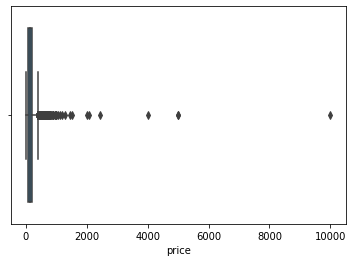

In [22]:
# Creating boxplot to find outliers in price
sns.boxplot(x = 'price', data = df_combined)

> The price of few airbnb's per day is above 4000, these outliers wont allow the ml model to be trained properly.

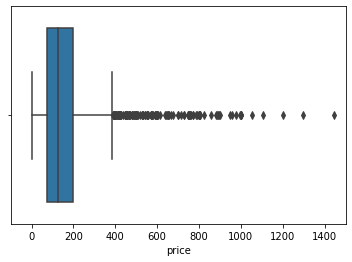

In [23]:
sns.boxplot(x = 'price', data = df_combined)
plt.xlim(-100,1500)
plt.show()

In [24]:
# Getting rid of outliers
df_combined = df_combined.loc[(df_combined.price < 1500) & (df_combined.price > 25)]

# Resetting index 
df_combined.reset_index(drop=True, inplace=True)

<AxesSubplot:xlabel='price', ylabel='Count'>

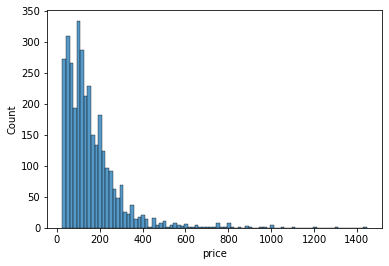

In [25]:
# Plotting histogram of updated data
sns.histplot(x = 'price', data = df_combined)

## Finding correlation

In [26]:
# Find correlation between price and other features
corr = df_combined.corr()
print(corr.price.sort_values(ascending=False)[0:60])
print(corr.price.sort_values(ascending=False)[60:89])

price                                             1.000000
accommodates                                      0.544161
bathrooms_text                                    0.515816
beds                                              0.500698
bedrooms                                          0.462771
room_type                                         0.417842
tv_or_hdtv                                        0.262354
shampoo                                           0.250616
gym                                               0.245659
pool                                              0.192780
instant_bookable                                  0.162902
dryer                                             0.161615
latitude                                          0.155936
longitude                                         0.143645
grill                                             0.143290
neighbourhood_cleansed_back_bay                   0.141480
linen                                             0.1412

In [28]:
# Creating correlation heat map
fig = px.imshow(corr, text_auto=True, width=4000, height=4000)
fig.show()

In [29]:
# Finding highly correlated feature pairs
corr_matrix = df_combined.corr().abs()
high_corr_var=np.where(corr_matrix>0.8)
high_corr_var=[(corr_matrix.columns[x],corr_matrix.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]
high_corr_var

[('host_response_time', 'host_response_rate'),
 ('accommodates', 'beds'),
 ('availability_30', 'availability_60'),
 ('availability_30', 'availability_90'),
 ('availability_60', 'availability_90'),
 ('number_of_reviews', 'no_en_comments'),
 ('number_of_reviews_ltm', 'reviews_per_month'),
 ('review_scores_rating', 'review_scores_value'),
 ('review_scores_rating', 'sentiment'),
 ('review_scores_value', 'sentiment'),
 ('refrigerator', 'microwave')]

> Removing host_response_time as it is highly correlated with host_response_rate

> Removing beds as it is highly correlated with accommodates

> Removing availability_60 and availability_90 as they are highly correlated with availability_30

> Removing no_en_comments as it is highly correlated with number_of_reviews

> Removing number_of_reviews_ltm as it is highly correlated with reviews_per_month

> Removing review_scores_rating and review_scores_value as they are highly correlated with sentiment

> Removing pet_allowed, housekeeping, concierge as these features became redundent when we removed price outliers from the data

> Removing id as it does not influence price

In [30]:
# Removing above mentioned features
drop_cols = ['host_response_time', 'beds', 'availability_60', 'availability_90', 'no_en_comments', 'number_of_reviews_ltm', 
             'review_scores_rating', 'review_scores_value', 'pet_allowed', 'housekeeping', 'concierge', 'id']
df_combined = df_combined.drop(drop_cols, axis=1)

In [31]:
df_combined

,neighbourhood_cleansed_back_bay,neighbourhood_cleansed_bay_village,neighbourhood_cleansed_beacon_hill,neighbourhood_cleansed_brighton,neighbourhood_cleansed_charlestown,neighbourhood_cleansed_chinatown,neighbourhood_cleansed_dorchester,neighbourhood_cleansed_downtown,neighbourhood_cleansed_east_boston,neighbourhood_cleansed_fenway,...,wifi,gym,free_parking,paid_parking,free_washer,paid_washer,sound_system_or_speaker,backyard_or_garden,tv_or_hdtv,sentiment
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.880005
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.847874
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.878070
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.883970
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.909710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3321,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.000000
3322,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000
3323,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000
3324,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000


## Data Exploration

In [33]:
df_final = df_combined

In [34]:
# Creating correlation heat map
corr = df_final.corr()
fig = px.imshow(corr, text_auto=True, width=4000, height=4000)
fig.show()

In [35]:
df_ammenities = df_final

drop_cols = ['neighbourhood_cleansed_back_bay', 'neighbourhood_cleansed_bay_village', 'neighbourhood_cleansed_beacon_hill', 
             'neighbourhood_cleansed_brighton', 'neighbourhood_cleansed_charlestown', 'neighbourhood_cleansed_chinatown', 
             'neighbourhood_cleansed_dorchester', 'neighbourhood_cleansed_downtown', 'neighbourhood_cleansed_east_boston',
             'neighbourhood_cleansed_fenway', 'neighbourhood_cleansed_hyde_park', 'neighbourhood_cleansed_jamaica_plain',
             'neighbourhood_cleansed_leather_district', 'neighbourhood_cleansed_longwood_medical_area', 
             'neighbourhood_cleansed_mattapan', 'neighbourhood_cleansed_mission_hill', 'neighbourhood_cleansed_north_end', 
             'neighbourhood_cleansed_roslindale', 'neighbourhood_cleansed_roxbury', 'neighbourhood_cleansed_south_boston',
             'neighbourhood_cleansed_south_boston_waterfront', 'neighbourhood_cleansed_south_end', 
             'neighbourhood_cleansed_west_end', 'neighbourhood_cleansed_west_roxbury', 'host_identity_verified', 
             'instant_bookable', 'reviews_pedf_finalr_month', 'oven', 'grill', 'beachfront', 'bidet', 'bike', 'breakfast', 'shampoo', 
             'linen', 'stove', 'air_conditioning', 'ac', 'refrigerator', 'sauna', 'game_console', 'heating', 'pool', 
             'lake_access', 'microwave', 'ev_charger', 'long_term_stay_allowed', 'cleaning_before_checkout', 
             'dedicated_workspace', 'dryer', 'wifi', 'gym', 'free_parking', 'paid_parking', 'free_washer', 'paid_washer', 
             'sound_system_or_speaker', 'backyard_or_garden', 'tv_or_hdtv']
df_ammenities = df_ammenities.drop(drop_cols, axis=1)

In [36]:
corr = df_ammenities.corr()
plt.figure(figsize=(5, 5), dpi=20)
corr.style.background_gradient(cmap='coolwarm')

,host_response_rate,host_acceptance_rate,latitude,longitude,room_type,accommodates,bathrooms_text,bedrooms,price,minimum_nights,maximum_nights,availability_30,availability_365,number_of_reviews,number_of_reviews_l30d,sentiment
host_response_rate,1.000000,0.727269,-0.075725,0.019864,-0.093622,0.077705,0.016688,0.069000,-0.100567,-0.380226,-0.206947,0.135412,0.197219,0.204304,0.249146,0.263698
host_acceptance_rate,0.727269,1.000000,-0.020266,0.040847,0.044278,0.183856,0.067687,0.111000,-0.025179,-0.540035,-0.168106,-0.029092,-0.027935,0.252922,0.319466,0.368679
latitude,-0.075725,-0.020266,1.000000,0.254806,0.227764,-0.018957,0.101546,-0.123619,0.155936,-0.002554,0.033497,-0.057617,-0.033270,0.021838,0.063222,-0.112843
longitude,0.019864,0.040847,0.254806,1.000000,0.205237,0.103237,0.122280,-0.009527,0.143645,-0.116975,0.005535,0.068568,0.040153,0.084602,0.097100,0.022777
room_type,-0.093622,0.044278,0.227764,0.205237,1.000000,0.436269,0.351410,0.200716,0.417842,-0.103286,0.076287,-0.133383,0.000224,0.014469,0.027457,-0.008681
accommodates,0.077705,0.183856,-0.018957,0.103237,0.436269,1.000000,0.566961,0.751976,0.544161,-0.181225,0.033811,-0.058797,-0.004672,0.050803,0.081407,0.125708
bathrooms_text,0.016688,0.067687,0.101546,0.122280,0.351410,0.566961,1.000000,0.560007,0.515816,-0.102563,-0.034421,0.001542,0.011277,-0.039288,0.023736,-0.021028
bedrooms,0.069000,0.111000,-0.123619,-0.009527,0.200716,0.751976,0.560007,1.000000,0.462771,-0.074023,-0.040337,-0.034375,-0.003396,-0.004344,0.041699,0.076057
price,-0.100567,-0.025179,0.155936,0.143645,0.417842,0.544161,0.515816,0.462771,1.000000,-0.099090,0.007218,0.026484,0.040719,-0.055147,-0.012815,-0.067702
minimum_nights,-0.380226,-0.540035,-0.002554,-0.116975,-0.103286,-0.181225,-0.102563,-0.074023,-0.099090,1.000000,0.153130,0.089065,0.069004,-0.241380,-0.305004,-0.272735


<Figure size 100x100 with 0 Axes>

In [37]:
corr = df_ammenities.corr()
fig = px.imshow(corr, text_auto=True, width=900, height=900)
fig.show()

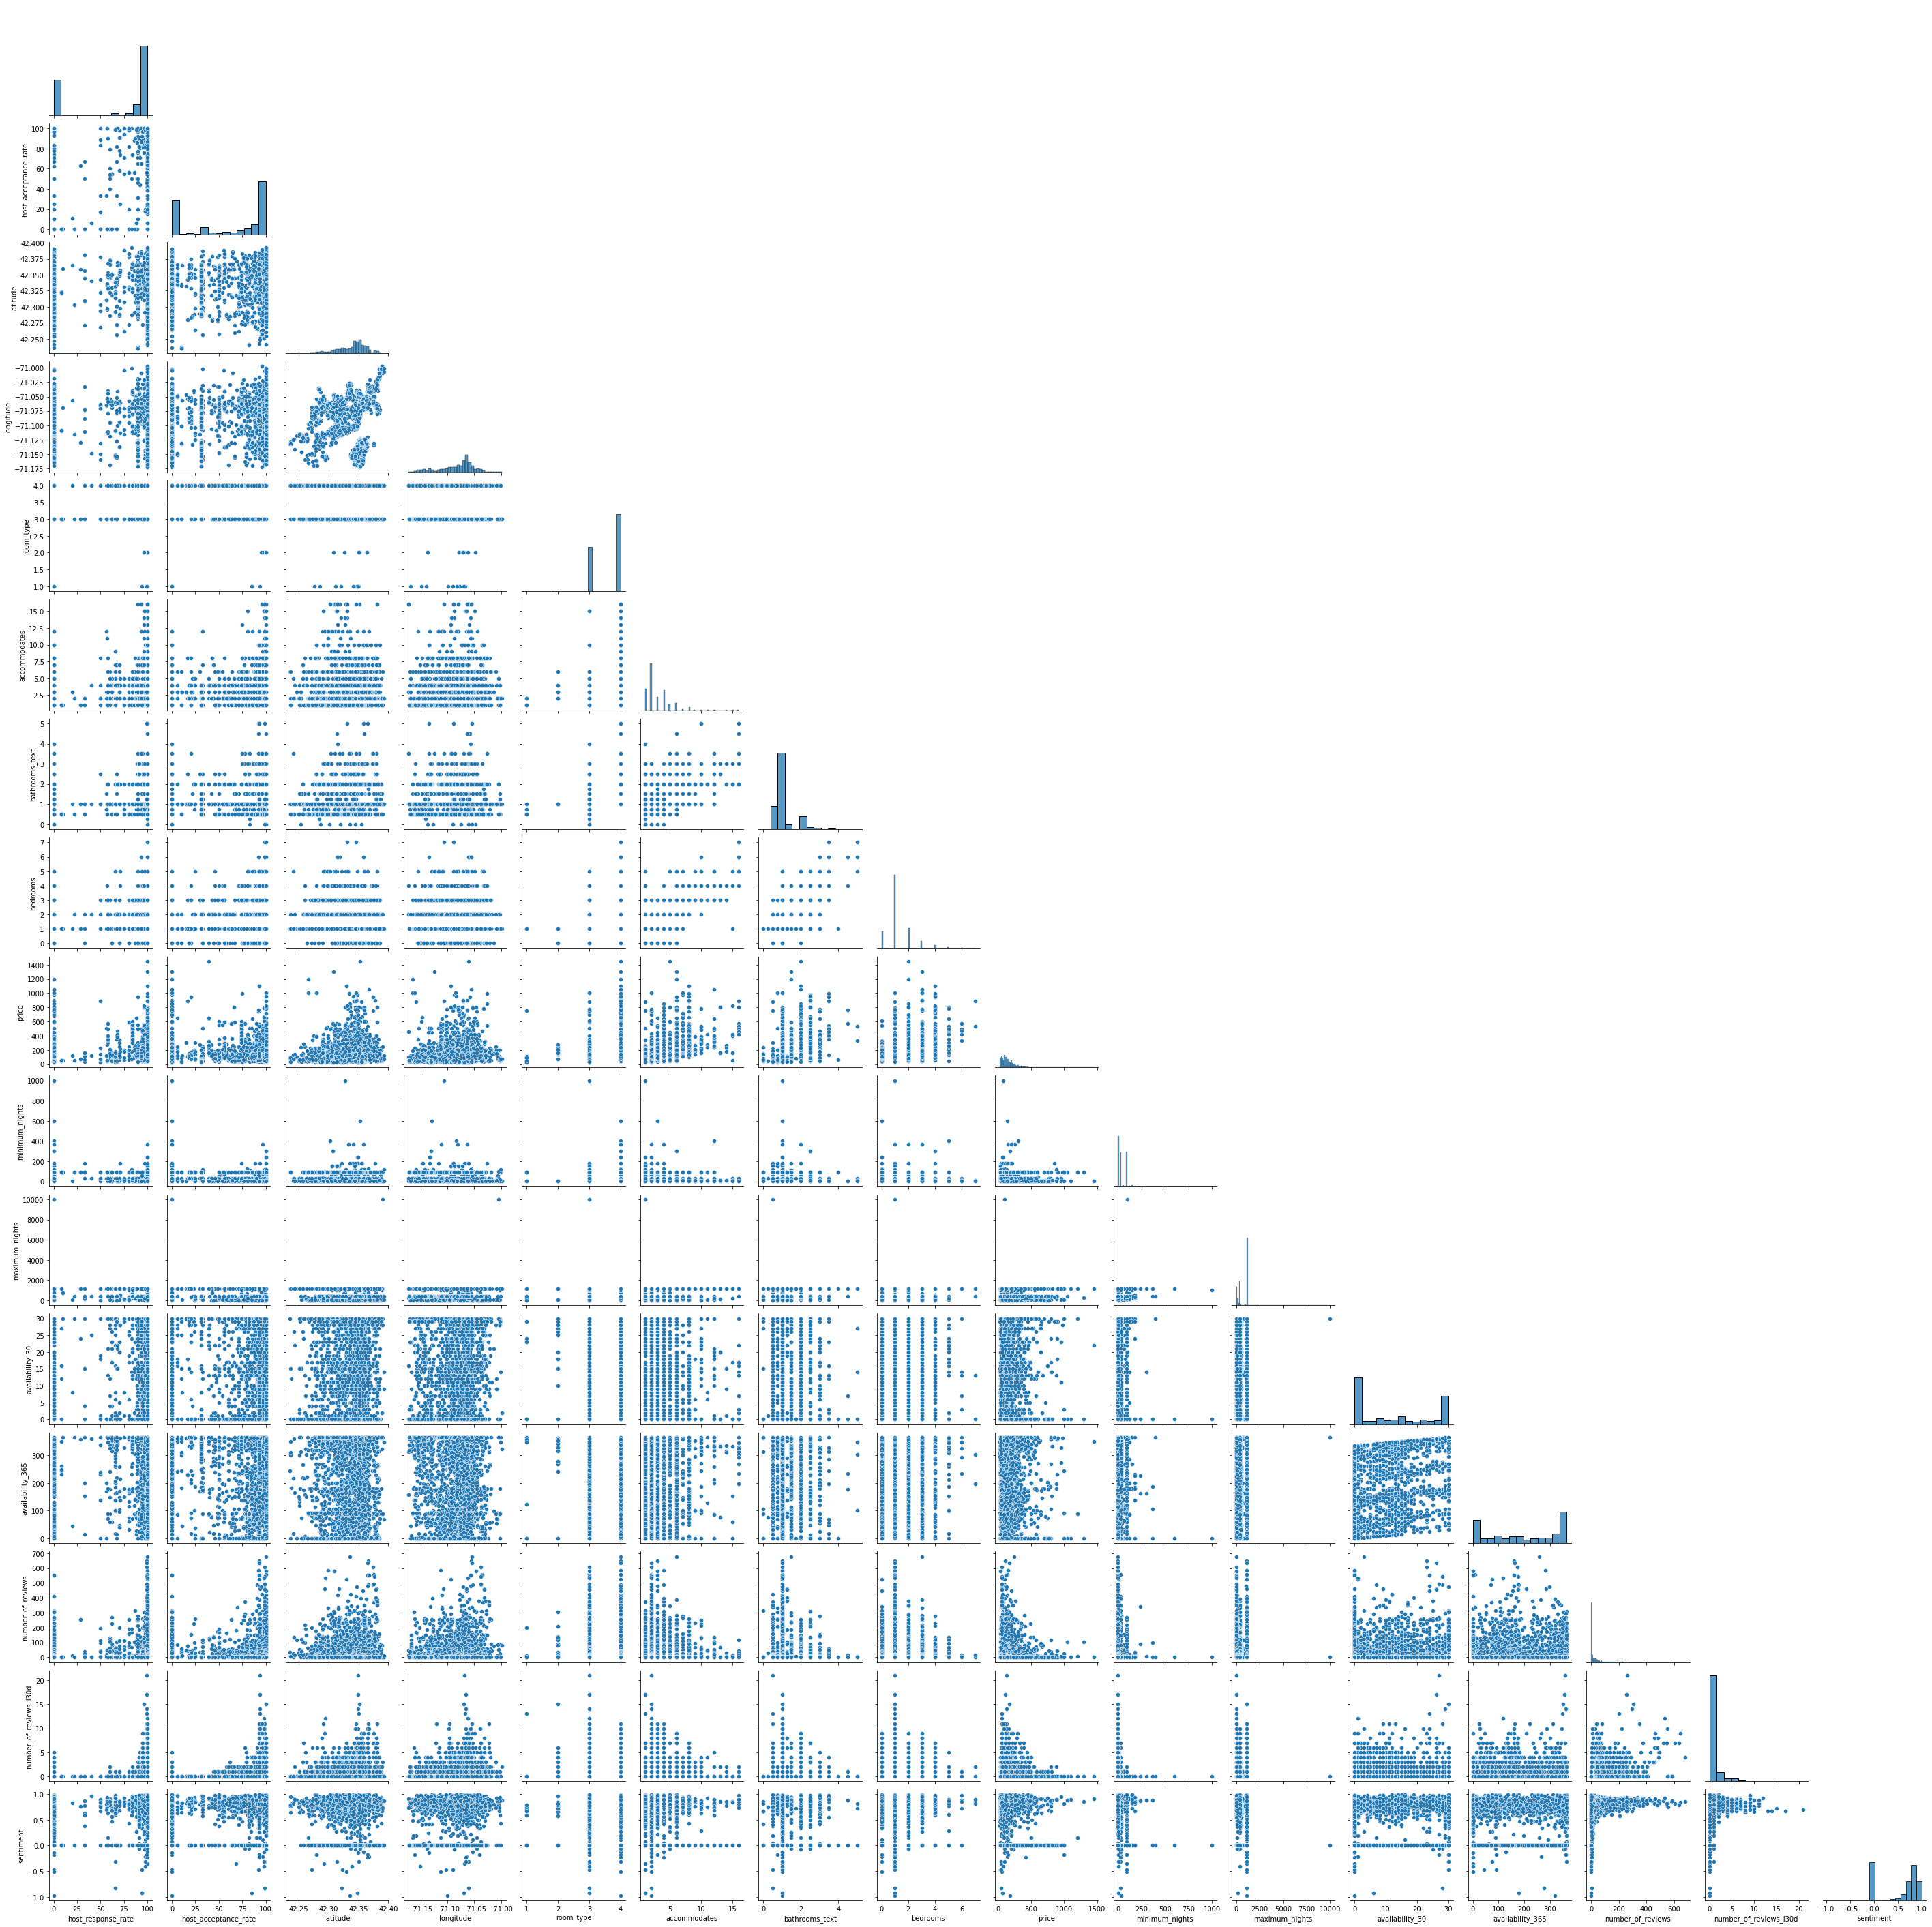

In [38]:
sns.pairplot(df_ammenities, corner = True)

## PCA

In [40]:
# Upload data
df_combined = df_final

In [41]:
# Dividing data into input and output variable
X = df_combined.drop('price', axis=1)
y = df_combined.price

# Splitting the data into the training set and test set before applying pca as test data should not influence training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [42]:
# Normalizing the data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [43]:
# Applying pca
pca = PCA()
X_train_0 = pca.fit_transform(X_train)
X_test_0 = pca.transform(X_test)

# Variance ratio for each princial component
pca.explained_variance_ratio_

array([0.06866228, 0.05866914, 0.04607258, 0.03648065, 0.03079387,
       0.02721551, 0.02500393, 0.02411614, 0.02065941, 0.01943984,
       0.0186417 , 0.01803686, 0.01728643, 0.01672928, 0.01644891,
       0.01632417, 0.01614264, 0.0157023 , 0.01547903, 0.01512192,
       0.01478895, 0.01470075, 0.01452338, 0.01437509, 0.01423095,
       0.01414261, 0.01405423, 0.01394655, 0.01387468, 0.01362681,
       0.01356768, 0.01341246, 0.01332428, 0.01316476, 0.01285465,
       0.01256507, 0.01232643, 0.01207063, 0.01187636, 0.01121447,
       0.01096694, 0.01055692, 0.01049651, 0.01014169, 0.01002882,
       0.00963212, 0.0091568 , 0.00899109, 0.0087    , 0.00857291,
       0.00821628, 0.00783974, 0.00772767, 0.00747528, 0.00732181,
       0.0070459 , 0.00659995, 0.00639716, 0.00605039, 0.00548594,
       0.00542307, 0.00502244, 0.00476976, 0.00464725, 0.00440063,
       0.00384543, 0.00252368, 0.00233404, 0.00199632, 0.00186858,
       0.00178339, 0.00175232, 0.00045713, 0.00010465])

In [44]:
# Applying pca with 50 principal components
pca = PCA(n_components = 50)
X_train_50 = pca.fit_transform(X_train)
X_test_50 = pca.transform(X_test)

# Sum of variance captured by 50 princial components
sum(pca.explained_variance_ratio_)

0.8885295455399796

In [45]:
# Applying pca with 41 principal components
pca = PCA(n_components = 41)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

# Sum of variance captured by 41 princial components
sum(pca.explained_variance_ratio_)

0.8015911193668052

> By selecting first 41 principal components we retain 80% of the variance and reduce number of features by 34

In [46]:
# Splitting the test data further into the validation set and test set as we will be using multiple models to validate best performing model
X_tes, X_val, y_tes, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

# Model Selection 

In [47]:
# Finding out baseline error
regressionSummary(y_val, [y_train.mean()]*len(y_val))

print('\n')

# Print R Squared value
print('R2 value:', metrics.r2_score(y_val, [y_train.mean()]*len(y_val)))


Regression statistics

                      Mean Error (ME) : -3.4335
       Root Mean Squared Error (RMSE) : 128.5591
            Mean Absolute Error (MAE) : 86.4045
          Mean Percentage Error (MPE) : -67.1680
Mean Absolute Percentage Error (MAPE) : 90.3182


R2 value: -0.0007137826440837269


## Linear Regression

In [48]:
# Initializing Linear Regression model
lin_reg = LinearRegression()

# Fiting the model
lin_reg.fit(X_train, y_train)

# Predicting
y_val_lin_reg = lin_reg.predict(X_val)

# Error summary
regressionSummary(y_val, y_val_lin_reg)

print('\n')

# Print R Squared value
print('R2 value:', metrics.r2_score(y_val, y_val_lin_reg))

df_linreg = pd.DataFrame(abs(y_val - y_val_lin_reg).values, columns = ['Linear Regression'])


Regression statistics

                      Mean Error (ME) : -0.9813
       Root Mean Squared Error (RMSE) : 88.6779
            Mean Absolute Error (MAE) : 54.0752
          Mean Percentage Error (MPE) : -21.9259
Mean Absolute Percentage Error (MAPE) : 47.5569


R2 value: 0.52385975425072


## KNN Regression

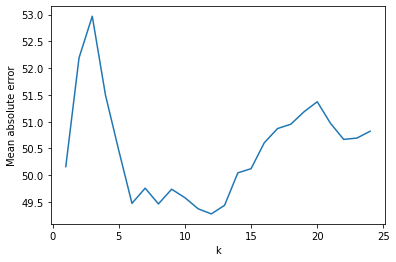


Regression statistics

                      Mean Error (ME) : 10.9910
       Root Mean Squared Error (RMSE) : 97.6507
            Mean Absolute Error (MAE) : 49.2786
          Mean Percentage Error (MPE) : -13.2278
Mean Absolute Percentage Error (MAPE) : 33.4293


R2 value: 0.4226287578585708


In [49]:
l = np.arange(1,25,1)
mae = []

# Finding the best k value for KNN regression
for a in l:
    knn_reg = KNeighborsRegressor(n_neighbors = a, weights = 'distance')
    knn_reg.fit(X_train,y_train)
    y_val_knn_reg = knn_reg.predict(X_val)
    mae.append(metrics.mean_absolute_error(y_val, y_val_knn_reg))

# Plotting MAE vs k graph
ax = plt.gca()
ax.plot(l, mae)
plt.xlabel("k")
plt.ylabel("Mean absolute error")
plt.show()

# Selecting 11 as value of k and initializing KNN
knn_reg = KNeighborsRegressor(n_neighbors = 12, weights = 'distance')

# Fiting the model
knn_reg.fit(X_train, y_train)

# Predicting
y_val_knn_reg = knn_reg.predict(X_val)

# Error summary
regressionSummary(y_val, y_val_knn_reg)

print('\n')

# Print R Squared value
print('R2 value:', metrics.r2_score(y_val, y_val_knn_reg))

df_knn = pd.DataFrame(abs(y_val - y_val_knn_reg).values, columns = ['KNN Regression'])

## Random Forest

In [50]:
# Initializing Random Forest model
rand_forest = RandomForestRegressor(n_jobs=-1) 

# Fiting the model
rand_forest.fit(X_train, y_train)

# Predicting
y_val_rand_forest = rand_forest.predict(X_val)

# Error summary
regressionSummary(y_val, y_val_rand_forest)

print('\n')

# Print R Squared value
print('R2 value:', metrics.r2_score(y_val, y_val_rand_forest))

df_randfor = pd.DataFrame(abs(y_val - y_val_rand_forest).values, columns = ['Random Forest'])


Regression statistics

                      Mean Error (ME) : -1.9489
       Root Mean Squared Error (RMSE) : 90.3120
            Mean Absolute Error (MAE) : 47.4950
          Mean Percentage Error (MPE) : -21.2372
Mean Absolute Percentage Error (MAPE) : 36.7093


R2 value: 0.5061494675526712


## Descion Trees

In [51]:
# Initializing Decision Tree model
decision_tree_reg = tree.DecisionTreeRegressor()

# Fiting the model
decision_tree_reg.fit(X_train, y_train)

# Predicting
y_val_dec_tree = decision_tree_reg.predict(X_val)

# Error summary
regressionSummary(y_val, y_val_dec_tree)

print('\n')

# Print R Squared value
print('R2 value:', metrics.r2_score(y_val, y_val_dec_tree))

df_dectree = pd.DataFrame(abs(y_val - y_val_dec_tree).values, columns = ['Descion Tree'])


Regression statistics

                      Mean Error (ME) : -2.0551
       Root Mean Squared Error (RMSE) : 142.6100
            Mean Absolute Error (MAE) : 67.3223
          Mean Percentage Error (MPE) : -19.5068
Mean Absolute Percentage Error (MAPE) : 47.0312


R2 value: -0.2314146373341932


## XGBoost

In [52]:
# Initializing XGBoost model
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

# Fiting the model
xgb_model.fit(X_train, y_train)

# Predicting
y_val_xgb = xgb_model.predict(X_val)

# Error summary
regressionSummary(y_val, y_val_xgb)

print('\n')

# Print R Squared value
print('R2 value:', metrics.r2_score(y_val, y_val_xgb))

df_xgb = pd.DataFrame(abs(y_val - y_val_xgb).values, columns = ['XGBoost'])


Regression statistics

                      Mean Error (ME) : 1.5275
       Root Mean Squared Error (RMSE) : 97.7101
            Mean Absolute Error (MAE) : 51.5468
          Mean Percentage Error (MPE) : -15.8927
Mean Absolute Percentage Error (MAPE) : 37.0897


R2 value: 0.4219258212910957


## Lasso Regression

In [53]:
# Initializing Lasso Regression model
lasso_reg = Lasso(tol = 0.01, random_state = 42)

# Fiting the model
lasso_reg.fit(X_train,y_train)

# Predicting
y_val_lasso = lasso_reg.predict(X_val)

# Error summary
regressionSummary(y_val, y_val_lasso)

print('\n')

# Print R Squared value
print('R2 value:', metrics.r2_score(y_val, y_val_lasso))

df_lasso = pd.DataFrame(abs(y_val - y_val_lasso).values, columns = ['Lasso'])


Regression statistics

                      Mean Error (ME) : -0.5183
       Root Mean Squared Error (RMSE) : 87.7179
            Mean Absolute Error (MAE) : 52.6968
          Mean Percentage Error (MPE) : -22.1239
Mean Absolute Percentage Error (MAPE) : 46.0505


R2 value: 0.534112358837384


## Neural Network

In [54]:
# Initializing Neural Network model
model = Sequential()
model.add(Dense(41, input_dim=41, kernel_initializer='normal', activation='relu'))
model.add(Dense(28, kernel_initializer='normal', activation='relu'))
model.add(Dense(14, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae'])

# Fiting the model
model.fit(X_train, y_train, epochs=80, batch_size=111)

# Predicting
y_val_nn = model.predict(X_val)

# Error summary
regressionSummary(y_val, y_val_nn[:,0])

print('\n')

# Print R Squared value
print('R2 value:', metrics.r2_score(y_val, y_val_nn[:,0]))

df_nn = pd.DataFrame(abs(y_val - y_val_nn[:,0]).values, columns = ['NN'])

Epoch 1/80
24/24 [==============================] - 0s 1ms/step - loss: 42754.9883 - mse: 42754.9883 - mae: 160.1337
Epoch 2/80
24/24 [==============================] - 0s 696us/step - loss: 42617.2539 - mse: 42617.2539 - mae: 159.7772
Epoch 3/80
24/24 [==============================] - 0s 696us/step - loss: 41858.7891 - mse: 41858.7891 - mae: 157.9549
Epoch 4/80
24/24 [==============================] - 0s 696us/step - loss: 38950.9062 - mse: 38950.9062 - mae: 151.1939
Epoch 5/80
24/24 [==============================] - 0s 696us/step - loss: 31307.4531 - mse: 31307.4531 - mae: 131.9475
Epoch 6/80
24/24 [==============================] - 0s 696us/step - loss: 18980.8750 - mse: 18980.8750 - mae: 93.1067
Epoch 7/80
24/24 [==============================] - 0s 2ms/step - loss: 10528.1416 - mse: 10528.1416 - mae: 61.2648
Epoch 8/80
24/24 [==============================] - 0s 652us/step - loss: 9364.2324 - mse: 9364.2324 - mae: 57.2978
Epoch 9/80
24/24 [==============================] - 0s 73

Epoch 71/80
24/24 [==============================] - 0s 652us/step - loss: 7153.0308 - mse: 7153.0308 - mae: 45.8334
Epoch 72/80
24/24 [==============================] - 0s 652us/step - loss: 7121.5879 - mse: 7121.5879 - mae: 45.6116
Epoch 73/80
24/24 [==============================] - 0s 652us/step - loss: 7124.2852 - mse: 7124.2852 - mae: 45.4696
Epoch 74/80
24/24 [==============================] - 0s 696us/step - loss: 7122.6450 - mse: 7122.6450 - mae: 46.2660
Epoch 75/80
24/24 [==============================] - 0s 696us/step - loss: 7095.3247 - mse: 7095.3247 - mae: 45.5319
Epoch 76/80
24/24 [==============================] - 0s 652us/step - loss: 7070.3896 - mse: 7070.3896 - mae: 45.6050
Epoch 77/80
24/24 [==============================] - 0s 652us/step - loss: 7065.2886 - mse: 7065.2886 - mae: 45.4732
Epoch 78/80
24/24 [==============================] - 0s 696us/step - loss: 7050.2021 - mse: 7050.2021 - mae: 45.7339
Epoch 79/80
24/24 [==============================] - 0s 652us/st

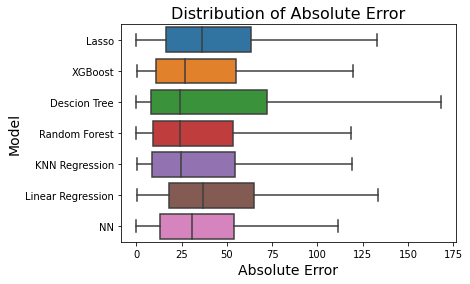

In [55]:
# Plotting distribution of absolute error
df_ae = pd.concat([df_lasso, df_xgb, df_dectree, df_randfor, df_knn, df_linreg, df_nn], axis=1)
boxplot = sns.boxplot(x="value", y="variable", data=pd.melt(df_ae), showfliers = False, orient="h")
boxplot.axes.set_title("Distribution of Absolute Error", fontsize=16)
boxplot.set_xlabel("Absolute Error", fontsize=14)
boxplot.set_ylabel("Model", fontsize=14)
plt.show()

#### Selecting NN as it has the best RMSE and R2 value

In [56]:
# Testing the Neural Network on the test data
# Predicting
y_tes_nn = model.predict(X_tes)

# Error summary
regressionSummary(y_tes, y_tes_nn[:,0])

print('\n')

# Print R Squared value
print('R2 value:', metrics.r2_score(y_tes, y_tes_nn[:,0]))


Regression statistics

                      Mean Error (ME) : 1.7827
       Root Mean Squared Error (RMSE) : 90.1051
            Mean Absolute Error (MAE) : 49.3285
          Mean Percentage Error (MPE) : -16.5353
Mean Absolute Percentage Error (MAPE) : 36.4658


R2 value: 0.5721732473712005
